# Tutorial: Variational algorithms on Hybrid jobs

## Hybrid Jobs

Amazon Braket Hybrid Jobs offers a way for you to run hybrid quantum-classical algorithms that require both classical resources and quantum processing units (QPUs). Hybrid Jobs is designed to spin up the requested classical compute, run your algorithm, and release the instances after completion so you only pay for what you use. This workflow is ideal for long-running iterative algorithms involving both classical and quantum resources. In this notebook we show you how to run such a job via the qiskit-braket provider.

Read more at https://docs.aws.amazon.com/braket/latest/developerguide/braket-jobs.html

## Prepare Files

### Prepare Hybrid Job Script

The job script defines the specific quantum logic to be executed on the quantum processor and the classical processing that the output is saved to, in this case, setting up the device backend and saving the job results to the EC2 instance. To learn more about what the VQE is, see this example: https://github.com/amazon-braket/amazon-braket-examples/blob/main/examples/hybrid_[…]lgorithms/VQE_Transverse_Ising/VQE_Transverse_Ising_Model.ipynb


In [3]:
! cat ./data/2_hybrid_jobs/job_script.py

"""Example of Hybrid Job payload with VQE."""
from braket.jobs import save_job_result
from qiskit.quantum_info import SparsePauliOp
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.algorithms.optimizers import SLSQP
from qiskit.circuit.library import TwoLocal
from qiskit.primitives import BackendEstimator

from qiskit_braket_provider import AWSBraketProvider


def main():
    # Sets up the "SV1" backend the quantum device, a default simulator provided by Amazon Braket.
    backend = AWSBraketProvider().get_backend("SV1")

    h2_op = SparsePauliOp(
        ["II", "IZ", "ZI", "ZZ", "XX"],
        coeffs=[
            -1.052373245772859,
            0.39793742484318045,
            -0.39793742484318045,
            -0.01128010425623538,
            0.18093119978423156,
        ],
    )

    estimator = BackendEstimator(backend=backend, options={"shots": 10})
    ansatz = TwoLocal(rotation_blocks="ry", entanglement_blocks="cz")
    slsqp = SLSQP(maxiter=1)

    vqe = VQE

In summary, this script sets up the hybrid job script that executes a VQE computation using a the Amazon Braket SV1 default simulator as the quantum backend and then saves the results of the computation to the EC2 instance the hybrid job is running on.

## Running your job
Amazon Braket provides a container for Hybrid Jobs that has the Qiskit-Braket provider and associated dependencies installed. To use the base container, call `retrieve_image(Framework.BASE, AwsSession().region)` as demonstrated below:

In [5]:
import time
from pprint import pprint
from braket.aws import AwsQuantumJob, AwsSession
from braket.jobs.image_uris import Framework, retrieve_image

job = AwsQuantumJob.create(
    device="arn:aws:braket:::device/quantum-simulator/amazon/sv1",
    source_module="data/2_hybrid_jobs/job_script.py",
    entry_point="job_script:main",
    wait_until_complete=False,
    job_name="qiskit-braket-vqe-"+str(int(time.time())),
    image_uri=retrieve_image(Framework.BASE, AwsSession().region),
)


In [7]:
result = job.result()
pprint(result)

{'VQE': {'eigenvalue': -0.49570779349360855,
         'optimal_parameters': [0.2196102979045742,
                                -3.634974011510415,
                                -3.8951343453580307,
                                4.911202213644824,
                                2.372597182173905,
                                -1.903856255621255,
                                -0.7605074501419118,
                                -4.839353619669662],
         'optimal_point': [0.2196102979045742,
                           -3.634974011510415,
                           -3.8951343453580307,
                           4.911202213644824,
                           2.372597182173905,
                           -1.903856255621255,
                           -0.7605074501419118,
                           -4.839353619669662],
         'optimal_value': -0.49570779349360855}}


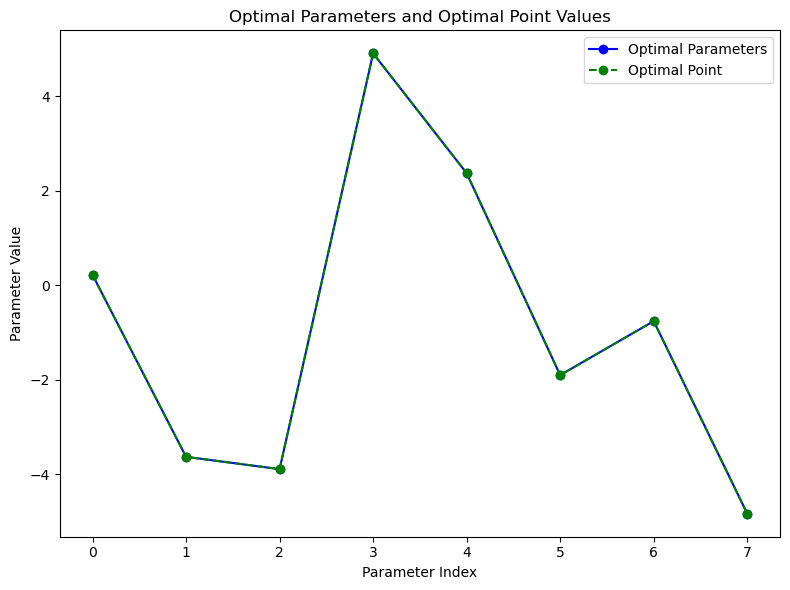

In [23]:
import matplotlib.pyplot as plt

# Extract data for visualization
optimal_parameters = result['VQE']['optimal_parameters']
optimal_point = result['VQE']['optimal_point']

# Create a single plot for both sets of data
plt.figure(figsize=(8, 6))

# Plot Optimal Parameters
plt.plot(optimal_parameters, marker='o', linestyle='-', color='b', label='Optimal Parameters')

# Plot Optimal Point Values
plt.plot(optimal_point, marker='o', linestyle='--', color='g', label='Optimal Point')

# Set labels and title
plt.xlabel('Parameter Index')
plt.ylabel('Parameter Value')
plt.title('Optimal Parameters and Optimal Point Values')

# Show legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()